# Model Creation Notebook

This notebook, we will cover the creation of machine learning models for prediction.

## 1. Import Libraries and Datasets

In [260]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)

import numpy as np 

import warnings
warnings.filterwarnings('ignore')

import joblib

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

# standardize the data
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [19]:
# Load the data
train_path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/transformed_data/transformed_train_data.csv'
val_path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/transformed_data/transformed_validation_data.csv'
test_path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/transformed_data/transformed_test_data.csv'

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

train_df.shape, val_df.shape, test_df.shape

((7007, 17), (875, 17), (875, 17))

## 2. Predictor vs Target Variable

In [21]:
train_df.head()

,rented_bike_count,hour,temperature,humidity,wind_speed,seasons,holiday,functioning_day,rainfall_class,snowfall_class,visibility_class,solar_radiation_class,year,month,day,day_of_week,lag_1
0,204,1,-5.5,38,0.8,3,0,1,0,0,2,0,2017,12,1,4,254.0
1,173,2,-6.0,39,1.0,3,0,1,0,0,2,0,2017,12,1,4,204.0
2,107,3,-6.2,40,0.9,3,0,1,0,0,2,0,2017,12,1,4,173.0
3,78,4,-6.0,36,2.3,3,0,1,0,0,2,0,2017,12,1,4,107.0
4,100,5,-6.4,37,1.5,3,0,1,0,0,2,0,2017,12,1,4,78.0


In [22]:
class XySplitter:
    def __init__(self, df, target='rented_bike_count'):
        self.df = df
        self.target = target

    def split(self):
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]
        return X, y
    
X_train, y_train = XySplitter(train_df).split()
X_val, y_val = XySplitter(val_df).split()
X_test, y_test = XySplitter(test_df).split()

In [24]:
X_train.head(), y_train.head()

(   hour  temperature  humidity  wind_speed  seasons  holiday  functioning_day  \
 0     1         -5.5        38         0.8        3        0                1   
 1     2         -6.0        39         1.0        3        0                1   
 2     3         -6.2        40         0.9        3        0                1   
 3     4         -6.0        36         2.3        3        0                1   
 4     5         -6.4        37         1.5        3        0                1   
 
    rainfall_class  snowfall_class  visibility_class  solar_radiation_class  \
 0               0               0                 2                      0   
 1               0               0                 2                      0   
 2               0               0                 2                      0   
 3               0               0                 2                      0   
 4               0               0                 2                      0   
 
    year  month  day  day_of_w

## 3. Model Selection
We will try out different model and evaluate them in this section

### 3.1 Baseline Model

In [246]:
class ModelTrainerEvaluator:
    def __init__(self, model):
        self.model = model

    def availability_error_metric(self, actual_demand, predicted_demand, weights=None):
        """
        Calculate the Availability Error Metric (AEM) to ensure enough items are available on time.
        
        Parameters:
        - actual_demand: A list or numpy array of actual demand values.
        - predicted_demand: A list or numpy array of predicted demand values.
        - weights: Optional list or numpy array of weights for each time period/item.
        
        Returns:
        - AEM (float): The calculated Availability Error Metric.
        """
    
        # Ensure inputs are numpy arrays
        actual_demand = np.array(actual_demand)
        predicted_demand = np.array(predicted_demand)
        
        # Calculate the shortfall (only positive differences)
        shortfall = np.maximum(0, actual_demand - predicted_demand)
        
        # If weights are provided, apply them
        if weights is not None:
            weights = np.array(weights)
            weighted_shortfall = shortfall * weights
            aem = np.sum(weighted_shortfall)
        else:
            aem = np.sum(shortfall)
        
        total_demand = np.sum(actual_demand)

        return aem / total_demand

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        return self.model

    def evaluate_model(self, X, y):
        y_pred = self.model.predict(X)
        y_pred = y_pred.astype(int)

        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        aem = self.availability_error_metric(y, y_pred)

        metrics = {"mse": mse, 
                   "rmse": rmse,
                   "mae": mae,
                   "r2": r2, 
                   "aem": aem}
        
        return metrics

    def train_evaluate(self, X_train, y_train, X_val, y_val):
        self.train_model(X_train, y_train)
        train_metrics = self.evaluate_model(X_train, y_train)
        val_metrics = self.evaluate_model(X_val, y_val)
        
        return self.model, train_metrics, val_metrics

    def print_metrics(self, metrics):
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

        print("\n")


base_model = LinearRegression()

model_trainer_evaluator = ModelTrainerEvaluator(base_model)
model, train_metrics, val_metrics = model_trainer_evaluator.train_evaluate(X_train,y_train, X_val, y_val)

model_trainer_evaluator.print_metrics(train_metrics)
model_trainer_evaluator.print_metrics(val_metrics)


mse: 67621.56115313258
rmse: 260.0414604503147
mae: 164.6794633937491
r2: 0.8409275424846403
aem: 0.11940709079881737


mse: 84903.05828571429
rmse: 291.38129364410867
mae: 187.2777142857143
r2: 0.8292526955682128
aem: 0.1438982806972773




### 3.2 Differnet Models

In [247]:
# To track unscaled performance
unscaled_model_metrics = {}

def do_train(alg_name, model, X_train, y_train, X_val, y_val):
    global unscaled_model_metrics

    model_trainer_evaluator = ModelTrainerEvaluator(model)
    model, train_metrics, val_metrics = model_trainer_evaluator.train_evaluate(X_train, y_train, X_val, y_val)

    unscaled_model_metrics[alg_name] = {'train': train_metrics, 
                         'val': val_metrics}

    return model

def check_overfitting(val_error, train_error):
    # Example: Relative Error Difference Threshold
    threshold = 0.1  # 10% threshold
    relative_diff = abs(val_error - train_error) / val_error


    if relative_diff > threshold:
        print(f"The model is likely overfitting. {relative_diff * 100}% Difference.")
        
    else:
        print(f"The model is generalizing well. {relative_diff * 100 }% Difference.")



#### 3.2.1 Without Scaling

In [248]:
# Define data
X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val

##### 3.2.1.1 Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
alg_name = "Gaussian-NB"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 70775.82117882118, 'rmse': np.float64(266.0372552459921), 'mae': 160.9717425431711, 'r2': 0.833507484660295, 'aem': np.float64(0.06350859228433028)} 

Validation Metrics: {'mse': 115040.41485714285, 'rmse': np.float64(339.17608237778626), 'mae': 219.04114285714286, 'r2': 0.7686438965311482, 'aem': np.float64(0.14957906539214383)} 

The model is likely overfitting. 21.563674719943705% Difference.


##### 3.2.1.2 Nearest Neighbour

In [251]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
alg_name = "Nearest-Neigbors"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 45849.84101612673, 'rmse': np.float64(214.12575981447614), 'mae': 132.31197374054517, 'r2': 0.892143175005862, 'aem': np.float64(0.08714183681913475)} 

Validation Metrics: {'mse': 102276.20114285714, 'rmse': np.float64(319.80650578569714), 'mae': 200.07542857142857, 'r2': 0.7943138209003184, 'aem': np.float64(0.11132573361531382)} 

The model is likely overfitting. 33.04521454671027% Difference.


##### 3.2.1.3 SVC

In [252]:
from sklearn.svm import NuSVR

model = NuSVR(degree=5, kernel='poly')
alg_name = "NuSVC"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 84263.03382331954, 'rmse': np.float64(290.2809567011235), 'mae': 198.04452690166977, 'r2': 0.8017802659476995, 'aem': np.float64(0.16162508530581424)} 

Validation Metrics: {'mse': 108612.14285714286, 'rmse': np.float64(329.56356421355633), 'mae': 243.64, 'r2': 0.7815717007624243, 'aem': np.float64(0.1712529218372893)} 

The model is likely overfitting. 11.919584498417976% Difference.


##### 3.2.1.4 Random Forest

In [253]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=8, 
                              max_leaf_nodes=200,
                              )
alg_name = "Random Forest"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 12235.048951048951, 'rmse': np.float64(110.61215553025333), 'mae': 65.5909804481233, 'r2': 0.971218361846798, 'aem': np.float64(0.04806161045408179)} 

Validation Metrics: {'mse': 18584.110857142856, 'rmse': np.float64(136.32355209993193), 'mae': 83.11428571428571, 'r2': 0.9626257652175461, 'aem': np.float64(0.05710919323355423)} 

The model is likely overfitting. 18.860568239030968% Difference.


##### 3.2.2.5 Compare Algorithms

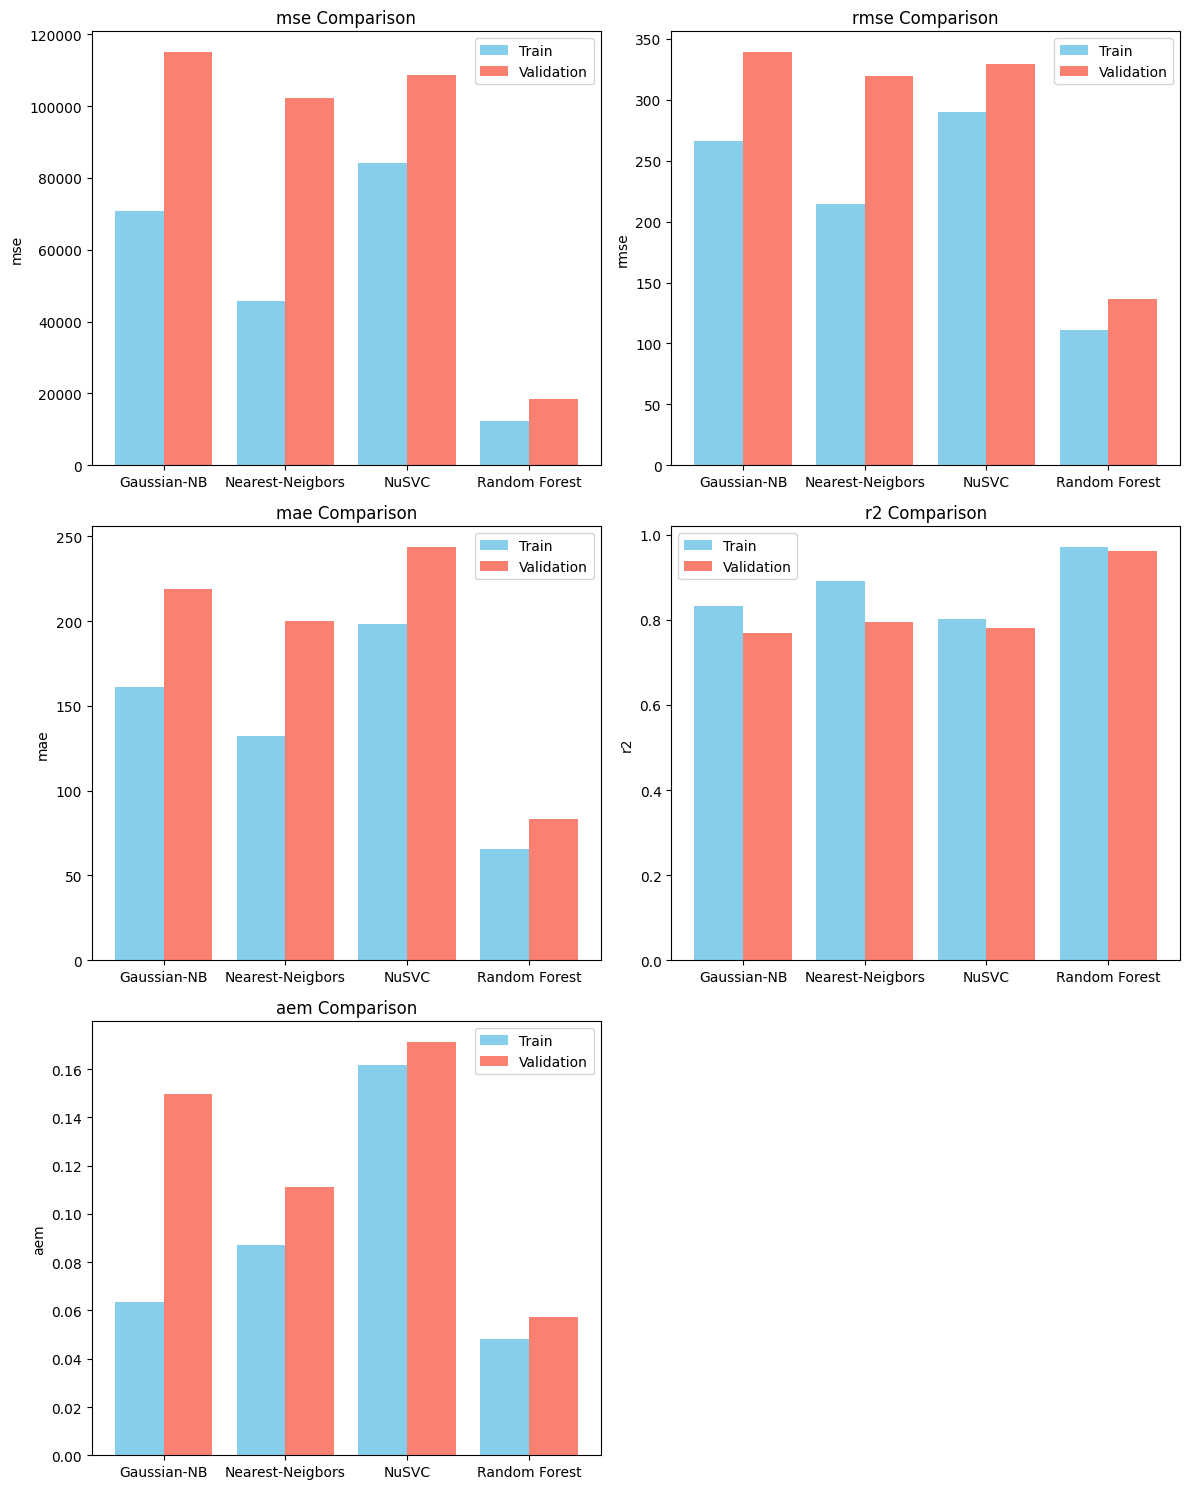

In [259]:
import matplotlib.pyplot as plt

def plot_comparisons(metrics):
    # Prepare data for plotting
    algorithms = list(metrics.keys())
    train_metrics = {metric: [] for metric in metrics['Gaussian-NB']['train'].keys()}
    val_metrics = {metric: [] for metric in metrics['Gaussian-NB']['train'].keys()}

    for algo in algorithms:
        for metric in metrics[algo]['train'].keys():
            train_metrics[metric].append(metrics[algo]['train'][metric])
            val_metrics[metric].append(metrics[algo]['val'][metric])

    # Create subplots for each metric
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))

    # Define the metrics
    metric_labels = list(train_metrics.keys())

    # Plot the metrics
    for i, metric in enumerate(metric_labels):
        ax = axes[i // 2, i % 2]
        ax.bar(np.arange(len(algorithms)) - 0.2, train_metrics[metric], width=0.4, label='Train', color='skyblue', align='center')
        ax.bar(np.arange(len(algorithms)) + 0.2, val_metrics[metric], width=0.4, label='Validation', color='salmon', align='center')
        ax.set_xticks(np.arange(len(algorithms)))
        ax.set_xticklabels(algorithms)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        ax.legend()

    # Remove empty subplot (since we have 5 metrics and 6 subplots)
    fig.delaxes(axes[2, 1])

    plt.tight_layout()
    plt.show()

plot_comparisons(unscaled_model_metrics)

#### 3.2.2 With Scaling

In [261]:
X_train.head()

,hour,temperature,humidity,wind_speed,seasons,holiday,functioning_day,rainfall_class,snowfall_class,visibility_class,solar_radiation_class,year,month,day,day_of_week,lag_1
0,1,-5.5,38,0.8,3,0,1,0,0,2,0,2017,12,1,4,254.0
1,2,-6.0,39,1.0,3,0,1,0,0,2,0,2017,12,1,4,204.0
2,3,-6.2,40,0.9,3,0,1,0,0,2,0,2017,12,1,4,173.0
3,4,-6.0,36,2.3,3,0,1,0,0,2,0,2017,12,1,4,107.0
4,5,-6.4,37,1.5,3,0,1,0,0,2,0,2017,12,1,4,78.0


In [269]:
scaler = MinMaxScaler().set_output(transform="pandas")

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_scaled

,hour,temperature,humidity,wind_speed,seasons,holiday,functioning_day,rainfall_class,snowfall_class,visibility_class,solar_radiation_class,year,month,day,day_of_week,lag_1
0,0.043478,0.215035,0.387755,0.108108,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,0.666667,0.071429
1,0.086957,0.206294,0.397959,0.135135,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,0.666667,0.057368
2,0.130435,0.202797,0.408163,0.121622,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,0.666667,0.048650
3,0.173913,0.206294,0.367347,0.310811,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,0.666667,0.030090
4,0.217391,0.199301,0.377551,0.202703,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000,0.666667,0.021935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7002,0.826087,0.716783,0.581633,0.297297,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.727273,0.566667,0.166667,0.000000
7003,0.869565,0.706294,0.591837,0.189189,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.727273,0.566667,0.166667,0.000000
7004,0.913043,0.697552,0.622449,0.202703,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.727273,0.566667,0.166667,0.000000
7005,0.956522,0.692308,0.663265,0.040541,0.666667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.727273,0.566667,0.166667,0.000000
